In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

/BS/orekondy/work/opt/anaconda2/envs/py27/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [62]:
import json
import os
from os import path as osp
import shutil

from PIL import Image, ImageDraw, ImageFilter

In [63]:
# Generate using: http://phrogz.net/css/distinct-colors.html
colors = ['#ff0000', '#ffcc00', '#00755e', '#da8fff', '#ff8f8f', '#757242', '#00eeff', '#ff00cc', '#752f00', '#ccff00', '#00aaff', '#75005e', '#ff8800', '#2f7500', '#426475', '#ff8fcb', '#ffcb8f', '#bcff8f', '#0044ff', '#ff0066', '#755d42', '#00ff00', '#001f75', '#750010', '#754e00', '#00ffaa', '#424975', '#754249']

def hex_to_rgb(value):
    """Return (red, green, blue) for the color given as #rrggbb."""
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

def rgb_to_hex(red, green, blue):
    """Return color as #rrggbb for the given color values."""
    return '#%02x%02x%02x' % (red, green, blue)

def get_mask(nx, ny, poly_verts_list, retain_instances=False, return_grid_list=False):
    """
    Represent a set of polygons on grid size (nx x ny) as a mask. This mask will be of size (nx, ny), the
    polygons represented 1s and the remaining areas with 0s.

    :param nx: grid width
    :param ny: grid height
    :param poly_verts_list: List of polygons in the format [ [(x1, y1), (x2, y2), ...], ...]
    :return:
    """
    if poly_verts_list == []:
        # In case there are no polygons, simply return an empty canvas
        return np.zeros((ny, nx))
    # Create vertex coordinates for each grid cell...
    # (<0,0> is at the top left of the grid in this system)
    # Source: https://stackoverflow.com/questions/3654289/scipy-create-2d-polygon-mask
    x, y = np.meshgrid(np.arange(nx), np.arange(ny))
    x, y = x.flatten(), y.flatten()

    points = np.vstack((x, y)).T

    grid_list = []
    for poly_verts in poly_verts_list:
        path = mpath(poly_verts)
        grid = path.contains_points(points)
        grid = grid.reshape((ny, nx))
        grid_list.append(grid)

    if return_grid_list:
        return grid_list

    if not retain_instances:
        combined_grid = reduce(lambda x, y: x | y, grid_list)
    else:
        combined_grid = np.zeros_like(grid_list[0])
        for idx in range(len(grid_list)):
            # Tag each instance with a particular number
            instance_id = idx + 1
            this_instance_grid = grid_list[idx]
            # Find pixels that have not been tagged with an instance yet
            unselected_pixels = np.logical_and(combined_grid == 0, this_instance_grid == 1)
            combined_grid[unselected_pixels] = instance_id
    return combined_grid.astype(int)

### Load Example Image + Annotation

In [4]:
annotation_file_path = '/home/orekondy/work2/datasets/VISPR2017-seg/phase0/annotations/tribhu_40m.json'
image_path = '/home/orekondy/work2/datasets/VISPR2017-seg/phase0/images_30/2017_19010723.jpg'

# Obtain annotation for this image
_, img_filename = osp.split(image_path)
anno_dct = dict()   # load annotation for this file here

with open(annotation_file_path) as jf:
    dct = json.load(jf)
    
    # This is a represented as <filename><size>
    for k, v in dct.iteritems():
        if v['filename'] == img_filename:
            anno_dct = v
            break

### Visualize original

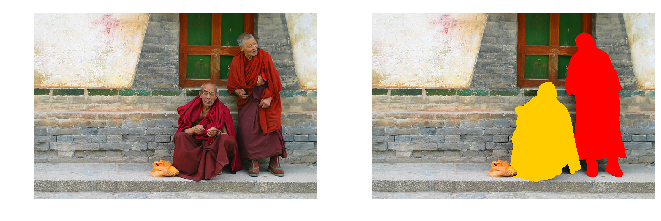

In [11]:
im = Image.open(image_path)
org_im_arr = np.asarray(im)

for idx, (region_id, region_dct) in enumerate(anno_dct['regions'].iteritems()):
    xy_list = zip(region_dct['shape_attributes']['all_points_x'], region_dct['shape_attributes']['all_points_y'])
    draw = ImageDraw.Draw(im)
    draw.polygon(xy_list, outline=None, fill=colors[idx])
    del draw

plt.subplot(121)
plt.axis('off')
plt.imshow(org_im_arr)
plt.subplot(122)
plt.axis('off')
plt.imshow(im)

### Select just one region for simplicity

In [13]:
im = Image.open(image_path)
poly =  zip(anno_dct['regions']['0']['shape_attributes']['all_points_x'], anno_dct['regions']['0']['shape_attributes']['all_points_y'])

## Outline

In [41]:
def draw_outline(org_im, poly):
    color_idx = 1
    
    im = org_im.copy()
    draw = ImageDraw.Draw(im, 'RGBA')
    
    # Fill
    r, g, b = hex_to_rgb(colors[color_idx])
    fill_col = (r, g, b, 100)
    # Outline
    draw.polygon(poly, fill=fill_col, outline=(255, 0, 0, 255))
    # draw.polygon(poly, outline=(255, 0, 0, 255))
    
    del draw
    
    return im

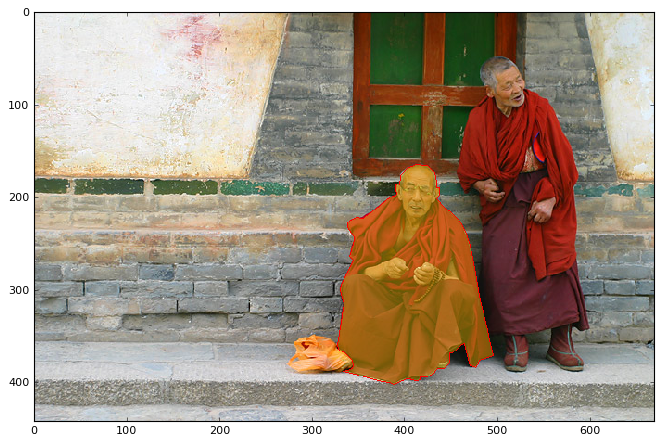

In [42]:
plt.imshow(draw_outline(im, poly))

In [56]:
def draw_outline_v2(org_im, poly):
    color_idx = 1
    col = colors[color_idx]
    
    im = org_im.copy()
    draw = ImageDraw.Draw(im, 'RGBA')
    draw.line(poly, fill='yellow', width=4)
    del draw
    
    return im

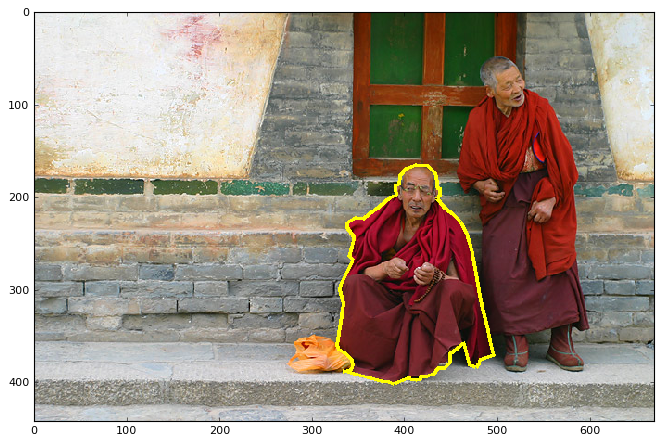

In [57]:
plt.clf()
plt.imshow(draw_outline_v2(im, poly))

## Fill Region

In [60]:
def fill_region(org_im, poly, fill_color='yellow'):
    im = org_im.copy()
    draw = ImageDraw.Draw(im)
    draw.polygon(poly, fill=fill_color)
    del draw
    
    return im

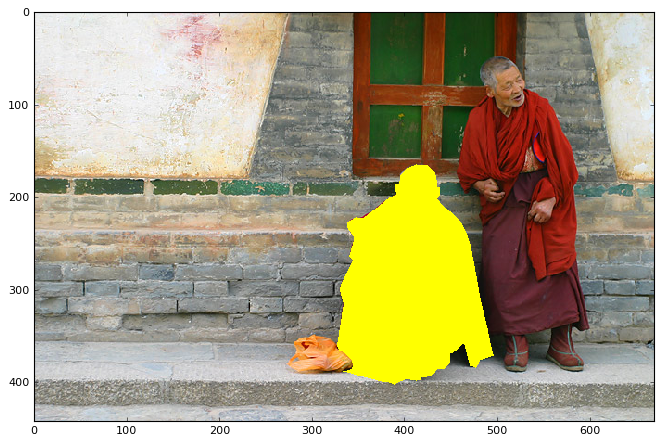

In [61]:
plt.clf()
plt.imshow(fill_region(im, poly))

## Blur region

In [121]:
def blur_region(org_im, poly, radius=2):
    im = org_im.copy()
    
    # Blur the entire image
    blurred_image = im.filter(ImageFilter.GaussianBlur(radius=radius))
    blurred_imArray = np.asarray(blurred_image)
    
    # Generate a mask for the polygon
    imArray = np.asarray(im).copy()
    maskIm = Image.new('L', (imArray.shape[1], imArray.shape[0]), 0)
    ImageDraw.Draw(maskIm).polygon(poly, outline=1, fill=1)
    mask = np.array(maskIm)
    
    # Copy this region from the blurred image on to the original
    imArray[mask.astype(bool)] = blurred_imArray[mask.astype(bool)]
    
    return imArray

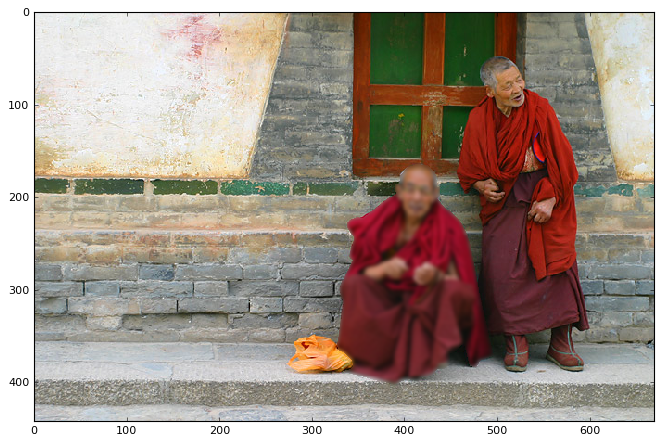

In [123]:
plt.clf()
plt.imshow(blur_region(im, poly, radius=2))

## Crop region

In [171]:
def crop_region(org_im, poly, return_cropped=True):
    im = org_im.copy()
    
    # Generate a mask for the polygon
    im_array = np.asarray(im).copy()
    mask_im = Image.new('L', (im_array.shape[1], im_array.shape[0]), 0)
    ImageDraw.Draw(mask_im).polygon(poly, outline=1, fill=1)
    mask = np.array(mask_im)
    
    new_im_array = np.ones_like(im_array) * 255
    
    # Copy this region from the blurred image on to the original
    new_im_array[mask.astype(bool)] = im_array[mask.astype(bool)]
    
    # Instance is most likely surrounded by whitespace. Crop such that this is removed
    if return_cropped:
        min_i = np.where(np.sum(mask, axis=1) > 0)[0][0]   # First non-zero element when summed column-wise
        min_j = np.where(np.sum(mask, axis=0) > 0)[0][0]   # First non-zero element when summed row-wise
        max_i = np.where(np.sum(mask, axis=1) > 0)[0][-1]   # Last non-zero element when summed column-wise
        max_j = np.where(np.sum(mask, axis=0) > 0)[0][-1]   # Last non-zero element when summed row-wise
    
        new_im_array = new_im_array[min_i:max_i, min_j:max_j]
    
    
    new_im = Image.fromarray(new_im_array)

    if new_im.mode != 'RGB':
        new_im = new_im.convert('RGB')
    
    return new_im

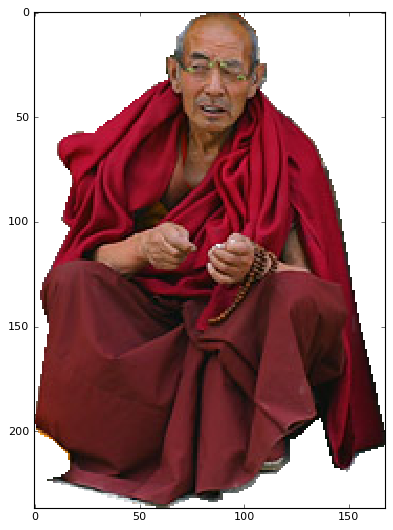

In [172]:
plt.clf()
plt.imshow(crop_region(im, poly))

## Square crop of cropped region

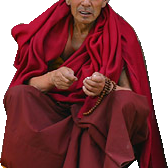

In [174]:
nim = crop_region(im, poly)
w, h = nim.size

# Take a square central crop
min_side_len = min(w, h)
x1 = w/2 - min_side_len/2
y1 = h/2 - min_side_len/2
x2 = w/2 + min_side_len/2
y2 = h/2 + min_side_len/2

nim.crop((x1, y1, x2, y2))